## Supervised Text Classification

### 4.1 Sentiment Prediction

In [1]:
# Import libraries
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [2]:
# Read data
df = pd.read_csv('Musical_Instruments_Reviews.csv')
# Insert temp variable
df.insert(0, 'Id', range(0, len(df)))
df.head()

,Id,Reviews
0,0,"Not much to write about here, but it does exac..."
1,1,The product does exactly as it should and is q...
2,2,The primary job of this device is to block the...
3,3,Nice windscreen protects my MXL mic and preven...
4,4,This pop filter is great. It looks and perform...


In [3]:
# Declare SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [5]:
# Run the polarity score on the dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    myid = row['Id']
    text = row['Reviews']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10254 [00:00<?, ?it/s]

In [6]:
# Create a separate dataset to contain polarity score result
vader = pd.DataFrame(res).T
vader = vader.reset_index().rename(columns={'index': 'Id'})
vader = vader.merge(df, how='left')
vader.head()

,Id,neg,neu,pos,compound,Reviews
0,0,0.057,0.790,0.153,0.6903,"Not much to write about here, but it does exac..."
1,1,0.000,0.819,0.181,0.9588,The product does exactly as it should and is q...
2,2,0.113,0.858,0.029,-0.7003,The primary job of this device is to block the...
3,3,0.055,0.746,0.199,0.5859,Nice windscreen protects my MXL mic and preven...
4,4,0.000,0.791,0.209,0.7650,This pop filter is great. It looks and perform...


In [7]:
# Classify sentiment based on compound score
sentiment = {}
for i in range (0,len(vader)):
    if (vader['compound'][i]) >= 0:
        sentiment[i] = 'Positive'
    else:
        sentiment[i] = 'Negative'

In [8]:
# Create a new dataframe to record the sentiment results 
sent_df = pd.DataFrame.from_dict(sentiment, orient ='index')
sent_df.rename(columns={0:'Sentiment'}, inplace = True)
sent_df.head()

,Sentiment
0,Positive
1,Positive
2,Negative
3,Positive
4,Positive


In [9]:
# Join the sentiment result dataframe with original dataframe
df['Sentiment'] = sent_df
# Drop temp variable
df.drop(['Id'], axis = 1, inplace=True)
df.head()

,Reviews,Sentiment
0,"Not much to write about here, but it does exac...",Positive
1,The product does exactly as it should and is q...,Positive
2,The primary job of this device is to block the...,Negative
3,Nice windscreen protects my MXL mic and preven...,Positive
4,This pop filter is great. It looks and perform...,Positive


In [10]:
# Export final dataset to csv
df.to_csv('Musical_Instruments_Sentiment.csv',index=False)

### 4.2	Naïve Bayes Classifier

In [11]:
# Read data
df = pd.read_csv('Musical_Instruments_Sentiment.csv')
df.head()

,Reviews,Sentiment
0,"Not much to write about here, but it does exac...",Positive
1,The product does exactly as it should and is q...,Positive
2,The primary job of this device is to block the...,Negative
3,Nice windscreen protects my MXL mic and preven...,Positive
4,This pop filter is great. It looks and perform...,Positive


In [12]:
import matplotlib.pyplot as plt

Value counts for Sentiment (pos, neg)
Positive    9258
Negative     996
Name: Sentiment, dtype: int64


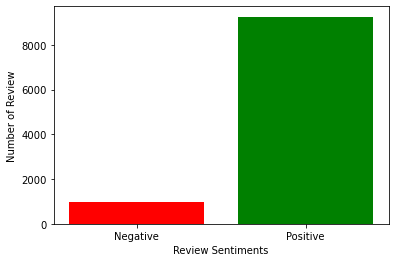

In [13]:
# Display sentiment distribution count
print("Value counts for Sentiment (pos, neg)")
print(df['Sentiment'].value_counts())
sentiment_count = df.groupby('Sentiment').count()

# Plot sentiment distribution using bar chart
plt.bar(sentiment_count.index.values, sentiment_count['Reviews'],
        color=('r','g'))
plt.xlabel("Review Sentiments")
plt.ylabel('Number of Review')

# Print chart
plt.show()

In [14]:
# Count Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1), 
                     tokenizer = token.tokenize)
text_counts=cv.fit_transform(df['Reviews'])

In [15]:
from sklearn.model_selection import train_test_split

# Split data to training and test set
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['Sentiment'], test_size=0.3, random_state=1)

In [16]:
# Build MultinomialNaiveBayes (MNB)
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

MNB_classifier = MultinomialNB().fit(X_train, y_train)
predicted_MNB = MNB_classifier.predict(X_test)

# Display results
print("Accuracy: ", metrics.accuracy_score(y_test,predicted_MNB))
print("\nClassification Report: \n", metrics.classification_report(y_test,predicted_MNB))

Accuracy:  0.8995775105622359

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.36      0.03      0.06       302
    Positive       0.90      0.99      0.95      2775

    accuracy                           0.90      3077
   macro avg       0.63      0.51      0.50      3077
weighted avg       0.85      0.90      0.86      3077



In [17]:
# Display confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,predicted_MNB)
print(cm)

[[   9  293]
 [  16 2759]]


In [18]:
# Cross validation report
print("Cross Validation Report ")
from sklearn.model_selection import cross_validate
MNB_classifier_CV1 = MultinomialNB().fit(X_train, y_train)
cv_score_1 = cross_validate(MNB_classifier_CV1, X_train, y_train, cv=5)
sorted(cv_score_1.keys())
cv_score_1['test_score']
print("Accuracy: %0.2f" % (cv_score_1['test_score'].mean()))

Cross Validation Report 
Accuracy: 0.90
